In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [239]:
data = pd.read_csv('energydata_complete.csv')

In [3]:
for num in data['RH_5']:
#     print(num)
    try:
        float(num)*0
    except:
        print('Non numerical value found')
        data.loc[data['RH_5']==num,'RH_5']=None

Non numerical value found


In [4]:
data['date']=pd.to_datetime(data['date'])
data['RH_5']=pd.to_numeric(data['RH_5'])

In [5]:
data2 = data.copy()
data2 = data2.set_index('date')
data2 = data2.sort_index(ascending=True)

In [6]:
def find_outliers(df):
    df2 = df.copy()
    cols = list(df.columns)
    cols.remove('Energy kWh')
#     print(cols)
    outlier_df = pd.DataFrame()
    clean_df = pd.DataFrame()
    df2['outlier']=''
    df2['column_value'] = ''
    for col in cols:
        q3 = np.quantile(df2[col],0.9)
        q1 = np.quantile(df2[col],0.1)
        iqr = q3-q1

        lower_range = q1 - (iqr*1.5)
        upper_range = q3 + (iqr*1.5)
        
        df2.loc[(df2[col]<lower_range)|(df2[col]>upper_range),['outlier','column_value']] = 'yes',col
        
    outlier_df = df2.loc[df2['outlier']=='yes']
    clean_df = df2.loc[df2['outlier']!='yes']
    clean_df = clean_df.loc[clean_df['Energy kWh']<7000]
        
    print('outlier_df:',outlier_df.shape)
    print('clean_df:',clean_df.shape)

    return outlier_df,clean_df

In [7]:
outlier_df,clean_df = find_outliers(data2)

outlier_df: (23, 27)
clean_df: (19709, 27)


In [126]:
data3 = clean_df.copy().reset_index()

data3['month']=data3.date.dt.month
data3['day']=data3.date.dt.day
data3['year']=data3.date.dt.year
data3['hour']=data3.date.dt.hour
data3['minute']=data3.date.dt.minute
data3['hours_in_minutes'] = (data3['hour']*60)+(data3['minute'])

data_ma = data3.copy()
# data_ma = data_ma.loc[data_ma['month']<=6]
data_ma = data_ma.drop(['outlier', 'column_value', 'month', 'day', 'year', 'hour',
       'minute', 'hours_in_minutes'],axis=1)

result = data_ma.set_index('date').resample(rule='60min', offset=pd.Timedelta(minutes=0, seconds=0)).interpolate(method='time')
result = result.dropna()
result.shape

(8136, 25)

In [127]:
data_ma2 = result.asfreq('60min')
data_ma2.shape
# print(data_ma2.shape)
# data_ma2.isna().sum()

(8136, 25)

In [128]:
def time_series_decomposition(data, variable):
    decomposition = seasonal_decompose(data[variable], model='additive',period=1440)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(12,2))
    plt.title('Trend')
    decomposition.trend.plot()
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.figure(figsize=(12,2))
    plt.title('Seasonality')
    decomposition.seasonal.plot()
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.figure(figsize=(12,2))
    plt.title('Residual')
    decomposition.resid.plot()
    plt.xticks(rotation = 90)
    plt.show()
    
    return trend, seasonal, residual

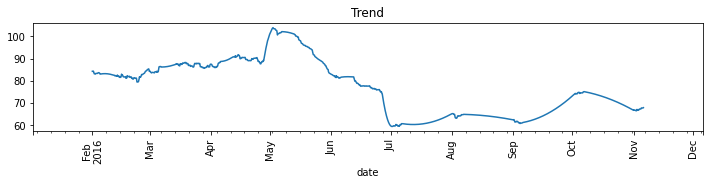

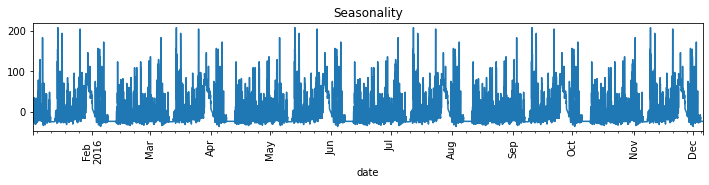

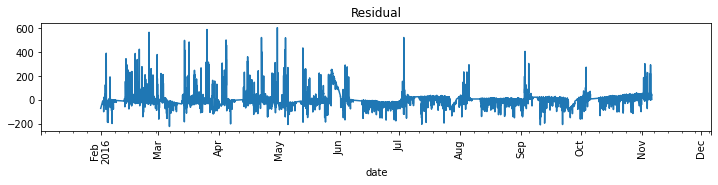

(date
 2016-01-02 00:00:00   NaN
 2016-01-02 01:00:00   NaN
 2016-01-02 02:00:00   NaN
 2016-01-02 03:00:00   NaN
 2016-01-02 04:00:00   NaN
                        ..
 2016-12-05 19:00:00   NaN
 2016-12-05 20:00:00   NaN
 2016-12-05 21:00:00   NaN
 2016-12-05 22:00:00   NaN
 2016-12-05 23:00:00   NaN
 Freq: 60T, Name: trend, Length: 8136, dtype: float64,
 date
 2016-01-02 00:00:00   -21.879343
 2016-01-02 01:00:00   -19.802264
 2016-01-02 02:00:00   -21.724905
 2016-01-02 03:00:00   -23.647265
 2016-01-02 04:00:00   -19.569346
                          ...    
 2016-12-05 19:00:00   -23.105512
 2016-12-05 20:00:00   -23.112533
 2016-12-05 21:00:00   -23.118156
 2016-12-05 22:00:00   -23.120299
 2016-12-05 23:00:00   -23.121045
 Freq: 60T, Name: seasonal, Length: 8136, dtype: float64,
 date
 2016-01-02 00:00:00   NaN
 2016-01-02 01:00:00   NaN
 2016-01-02 02:00:00   NaN
 2016-01-02 03:00:00   NaN
 2016-01-02 04:00:00   NaN
                        ..
 2016-12-05 19:00:00   NaN
 2016-12-

In [129]:
time_series_decomposition(data_ma2,'Energy kWh')

In [130]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', round(result[1],5))
    if round(result[1],5)>0.05:
        print('Data is non stationarity')
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, ':', value)

In [131]:
for col in data_ma2.columns:
    if col!='RH_5':
        print('Stationarity test for', col)
        check_stationarity(data[col])
        print()

Stationarity test for Energy kWh
ADF Statistic: -25.052352598337936
p-value: 0.0
Critical Values:
1% : -3.430681667501622
5% : -2.861686585263946
10% : -2.5668480233506488

Stationarity test for T1
ADF Statistic: -6.475184294371836
p-value: 0.0
Critical Values:
1% : -3.430681684324357
5% : -2.8616865926985824
10% : -2.5668480273079757

Stationarity test for RH_1
ADF Statistic: -5.779544542615275
p-value: 0.0
Critical Values:
1% : -3.430681852645618
5% : -2.8616866670864476
10% : -2.5668480669033364

Stationarity test for T2
ADF Statistic: -10.248292788976752
p-value: 0.0
Critical Values:
1% : -3.430681600227742
5% : -2.8616865555329394
10% : -2.566848007525354

Stationarity test for RH_2
ADF Statistic: -11.159905527972775
p-value: 0.0
Critical Values:
1% : -3.4306816338612705
5% : -2.8616865703969347
10% : -2.566848015437199

Stationarity test for T3
ADF Statistic: -4.0031174503803415
p-value: 0.00139
Critical Values:
1% : -3.4306819874256798
5% : -2.8616867266511186
10% : -2.566848098

In [132]:
data_ma3 = data_ma2.copy()
data_ma3 = data_ma3.reset_index()
data_ma3['date2'] =data_ma3.date.dt.date

In [133]:
train_data = data_ma3.loc[data_ma3['date2']<pd.to_datetime('2016-08-01')]
test_data = data_ma3.loc[data_ma3['date2']>=pd.to_datetime('2016-08-01')]

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [134]:
train_data = train_data.set_index('date')
train_data = train_data.drop('date2',axis=1)
# train_data = train_data.asfreq('30min')

test_data = test_data.set_index('date')
test_data = test_data.drop('date2',axis=1)
# test_data = test_data.asfreq('30min')

In [121]:
# train_data = np.log(train_data)
# test_data = np.log(test_data)

In [171]:
model = VAR(train_data)
model_fit = model.fit(15)

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [172]:
forecast = model_fit.forecast(model_fit.y, steps=len(test_data))

mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Mean Squared Error: 118.2780611011812
Root Mean Squared Error: 10.875571759736644
Mean Absolute Error: 5.3821261044234605


In [173]:
fc = pd.DataFrame(forecast)
fc.index = test_data.index
fc.columns = test_data.columns
fc = fc.reset_index()
fc['date2'] = fc.date.dt.date

metrics = pd.DataFrame()
for cols in test_data.columns:
    loc_metrics = {}

    mse = mean_squared_error(test_data[cols], fc[cols])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data[cols], fc[cols])
    
    loc_metrics['column_name'] = cols
    loc_metrics['mse'] = mse
    loc_metrics['rmse'] = rmse
    loc_metrics['mae'] = mae
        
    loc_metrics = pd.DataFrame(loc_metrics, index=[0])
        
    metrics = pd.concat([metrics,loc_metrics],axis=0)

In [174]:
metrics

,column_name,mse,rmse,mae
0,Energy kWh,1613.481714,40.168168,25.055090
0,T1,2.583042,1.607184,1.394001
0,RH_1,25.492468,5.049007,4.242290
0,T2,3.894100,1.973348,1.693607
0,RH_2,20.768193,4.557213,3.688078
0,T3,4.903784,2.214449,1.903141
0,RH_3,14.289357,3.780127,3.262876
0,T4,4.177000,2.043771,1.724437
0,RH_4,22.964128,4.792090,4.202594
0,T5,4.651019,2.156622,1.824969


In [175]:
from sklearn.ensemble import IsolationForest

In [178]:
data3 = data2.copy().reset_index()

data3['month']=data3.date.dt.month
data3['day']=data3.date.dt.day
data3['year']=data3.date.dt.year
data3['hour']=data3.date.dt.hour
data3['minute']=data3.date.dt.minute
data3['hours_in_minutes'] = (data3['hour']*60)+(data3['minute'])

data_ma = data3.copy()
# data_ma = data_ma.loc[data_ma['month']<=6]
data_ma = data_ma.drop(['month', 'day', 'year', 'hour',
       'minute', 'hours_in_minutes'],axis=1)

result = data_ma.set_index('date').resample(rule='30min', offset=pd.Timedelta(minutes=0, seconds=0)).interpolate(method='time')
result = result.dropna()
result.shape

(16272, 25)

In [179]:
data_ma3 = data_ma2.copy()
data_ma3 = data_ma3.reset_index()
data_ma3['date2'] =data_ma3.date.dt.date

In [183]:
train_data = data_ma3.loc[data_ma3['date2']<pd.to_datetime('2016-08-01')]
test_data = data_ma3.loc[data_ma3['date2']>=pd.to_datetime('2016-08-01')]

train_data = train_data.set_index('date')
train_data = train_data.drop('date2',axis=1)
# train_data = train_data.asfreq('30min')

test_data = test_data.set_index('date')
test_data = test_data.drop('date2',axis=1)
# test_data = test_data.asfreq('30min')

In [208]:
model = IsolationForest(contamination=0.01)  # Set the contamination level
model.fit(train_data)

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.01)

In [209]:
predictions = model.predict(test_data)

In [210]:
anomaly_threshold = -0.1  # Set a threshold for anomaly detection
anomaly_indices = np.where(predictions < anomaly_threshold)[0]
anomalies = test_data.iloc[anomaly_indices]
anomalies

,Energy kWh,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
date,,,,,,,,,,,,,,,,,,,,,
2016-08-05 10:00:00,410.0,24.600000,42.060000,29.663333,32.223333,26.200,38.511250,25.000000,40.163333,23.356667,...,24.500000,45.947500,23.100000,44.700000,20.6,752.1,53.0,2.0,40.0,10.6
2016-08-05 18:00:00,60.0,25.100000,35.626667,25.790000,30.760000,26.290,37.200000,24.963333,35.163333,24.426667,...,24.642857,33.325714,23.100000,37.700000,25.7,750.6,24.0,7.0,40.0,3.6
2016-08-05 19:00:00,50.0,25.100000,35.200000,25.600000,30.730000,26.200,36.834000,24.890000,34.700000,24.500000,...,24.540000,33.134000,23.100000,37.326667,25.1,750.6,27.0,5.0,29.0,4.6
2016-10-05 19:00:00,100.0,25.230000,48.663333,24.310000,48.178000,26.000,44.497143,25.390000,46.530000,25.066667,...,26.000000,50.500000,24.133333,47.260000,18.7,749.1,80.0,3.0,40.0,15.2
2016-11-05 17:00:00,70.0,25.463333,50.530000,25.451429,48.637143,26.175,45.855000,26.000000,46.621429,24.066667,...,26.600000,49.526667,24.100000,48.076000,22.7,746.6,56.0,2.0,40.0,13.4
2016-11-05 18:00:00,110.0,25.426667,51.363333,25.500000,47.694286,26.290,46.500000,25.890000,47.584286,23.963333,...,26.700000,50.333333,24.100000,49.356000,22.0,746.2,59.0,1.0,40.0,13.7
2016-11-05 20:00:00,100.0,25.500000,49.126667,24.736000,47.420000,26.200,45.500000,25.700000,46.200000,24.566667,...,26.700000,51.663333,23.890000,48.400000,18.1,745.5,69.0,1.0,40.0,12.3
2016-12-05 17:00:00,100.0,25.533333,49.260000,25.500000,46.928571,26.200,45.334000,25.614286,44.384286,24.200000,...,26.100000,50.230000,24.200000,47.075000,21.2,744.1,57.0,2.0,29.0,12.4
2016-12-05 18:00:00,100.0,25.600000,53.260000,25.500000,46.790000,26.200,45.332000,25.600000,44.225714,24.200000,...,26.700000,48.926667,24.160000,46.714000,21.2,744.1,54.0,4.0,29.0,11.6


In [222]:
from statsmodels.tsa.arima.model import ARIMA
from pyculiarity import detect_ts

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyculiarity import detect_ts

In [216]:
train_data = data_ma3.loc[data_ma3['date2']<pd.to_datetime('2016-08-01')]
test_data = data_ma3.loc[data_ma3['date2']>=pd.to_datetime('2016-08-01')]

train_data = train_data.set_index('date')
train_data = train_data.drop('date2',axis=1)
# train_data = train_data.asfreq('30min')

test_data = test_data.set_index('date')
test_data = test_data.drop('date2',axis=1)
# test_data = test_data.asfreq('30min')

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [223]:
model = SARIMAX(train_data['Energy kWh'], order=(1, 0, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [224]:
forecast = model_fit.get_forecast(steps=len(test_data))

In [240]:
forecasted_values = forecast.predicted_mean
lower_confidence_interval = forecast.conf_int().iloc[:, 0]
upper_confidence_interval = forecast.conf_int().iloc[:, 1]

In [241]:
# forecasted_data = pd.DataFrame({'Date': test_data.index, 'Energy kWh': forecasted_values,
#                                 'LowerCI': lower_confidence_interval, 'UpperCI': upper_confidence_interval})

forecasted_data = pd.DataFrame({'timestamp': test_data.index, 'value': forecasted_values})

In [242]:
results = detect_ts(forecasted_data, max_anoms=0.05, alpha=0.05, direction='both', only_last='day')

TypeError: sum() got an unexpected keyword argument 'axis'

In [230]:
forecasted_values

2016-08-01 00:00:00    76.670493
2016-08-01 01:00:00    78.684436
2016-08-01 02:00:00    74.373204
2016-08-01 03:00:00    69.433883
2016-08-01 04:00:00    71.106609
                         ...    
2016-12-05 19:00:00    97.111433
2016-12-05 20:00:00    89.694344
2016-12-05 21:00:00    93.935153
2016-12-05 22:00:00    84.802545
2016-12-05 23:00:00    84.271400
Freq: H, Name: predicted_mean, Length: 3048, dtype: float64

In [243]:
test_data.shape

(3048, 25)